<a href="https://colab.research.google.com/github/FindPrint/Epidemic-Propagation-Case-Study/blob/main/Epidemic_Propagation_Case_Study.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import pandas as pd

# Charger le fichier FluNet déjà présent
flu = pd.read_csv("VIW_FNT.csv")

# Filtrer sur le Canada
flu_canada = flu[flu['COUNTRY_AREA_TERRITORY'] == 'Canada'][['ISO_YEAR','ISO_WEEK','INF_ALL']].copy()

# Créer une colonne date à partir de ISO_YEAR + ISO_WEEK
flu_canada['date'] = pd.to_datetime(
    flu_canada['ISO_YEAR'].astype(str) + flu_canada['ISO_WEEK'].astype(str) + '1',
    format='%Y%W%w',
    errors='coerce'
)

# Nettoyer et trier
flu_canada = flu_canada.dropna(subset=['date']).set_index('date').sort_index()

# Normaliser par population (Canada ~ 38M)
flu_canada['cases_per_100k'] = (flu_canada['INF_ALL'] / 38_000_000) * 100000

# Aperçu
print(flu_canada.head())


            ISO_YEAR  ISO_WEEK  INF_ALL  cases_per_100k
date                                                   
1997-01-06      1997         1      NaN             NaN
1997-01-13      1997         2    174.0        0.457895
1997-01-20      1997         3    157.0        0.413158
1997-01-27      1997         4     93.0        0.244737
1997-02-03      1997         5     81.0        0.213158


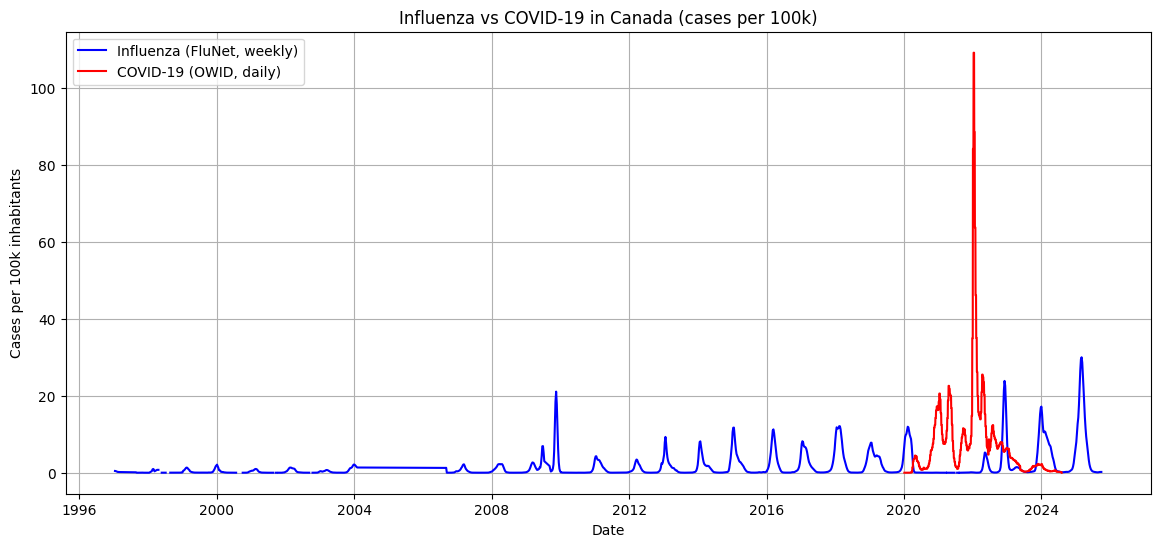

In [5]:
import matplotlib.pyplot as plt

# --- COVID-19 (Canada) ---
covid = pd.read_csv("owid-covid-data.csv")
covid_canada = covid[covid['location'] == 'Canada'][['date','new_cases','population']].copy()
covid_canada['date'] = pd.to_datetime(covid_canada['date'])
covid_canada = covid_canada.set_index('date').sort_index()
covid_canada['cases_per_100k'] = (covid_canada['new_cases'] / covid_canada['population']) * 100000
covid_canada['cases_per_100k_smoothed'] = covid_canada['cases_per_100k'].rolling(7, min_periods=1).mean()

# --- Influenza (Canada, déjà préparé) ---
flu_canada['cases_per_100k_smoothed'] = flu_canada['cases_per_100k'].rolling(3, min_periods=1).mean()

# --- Plot ---
plt.figure(figsize=(14,6))
plt.plot(flu_canada.index, flu_canada['cases_per_100k_smoothed'],
         label="Influenza (FluNet, weekly)", color="blue")
plt.plot(covid_canada.index, covid_canada['cases_per_100k_smoothed'],
         label="COVID-19 (OWID, daily)", color="red")
plt.title("Influenza vs COVID-19 in Canada (cases per 100k)")
plt.ylabel("Cases per 100k inhabitants")
plt.xlabel("Date")
plt.legend()
plt.grid(True)
plt.show()


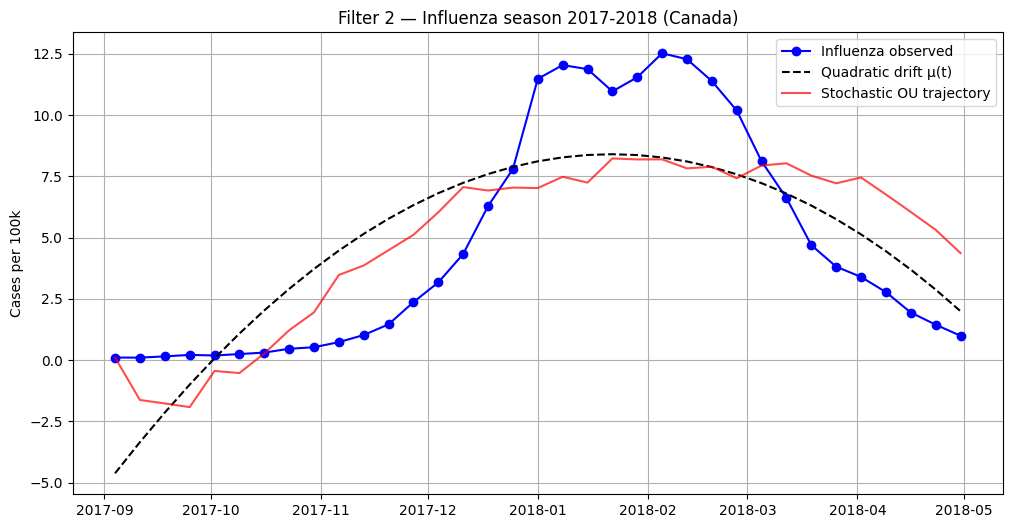

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# --- 1. Choisir une période (Influenza saison 2017-2018)
flu_season = flu_canada.loc["2017-09-01":"2018-05-01"]

# --- 2. Définir la fonction quadratique
def quadratic(t, a, b, c):
    return a*t**2 + b*t + c

# --- 3. Ajuster la dérive quadratique
t = np.arange(len(flu_season))
y = flu_season['cases_per_100k'].values
params, _ = curve_fit(quadratic, t, y)
a, b, c = params

# --- 4. Générer la trajectoire déterministe
mu = quadratic(t, a, b, c)

# --- 5. Ajouter une composante stochastique (OU simplifié)
gamma = 0.3
D = 0.05
phi = [y[0]]
for i in range(1, len(t)):
    drift = -gamma * (phi[-1] - mu[i])
    noise = np.sqrt(2*D) * np.random.randn()
    phi.append(phi[-1] + drift + noise)

# --- 6. Visualisation
plt.figure(figsize=(12,6))
plt.plot(flu_season.index, y, 'o-', label="Influenza observed", color="blue")
plt.plot(flu_season.index, mu, '--', label="Quadratic drift μ(t)", color="black")
plt.plot(flu_season.index, phi, '-', label="Stochastic OU trajectory", color="red", alpha=0.7)
plt.title("Filter 2 — Influenza season 2017-2018 (Canada)")
plt.ylabel("Cases per 100k")
plt.legend()
plt.grid(True)
plt.show()


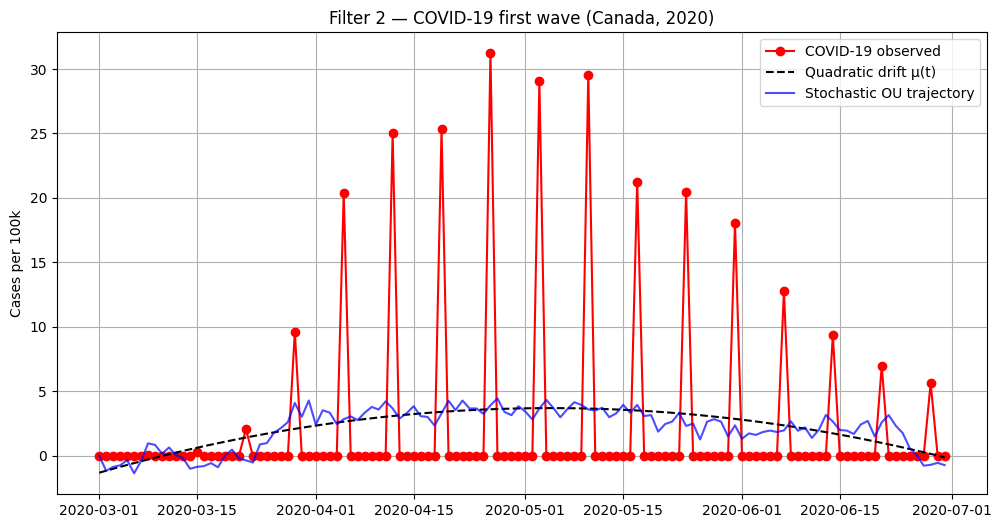

In [7]:
# --- 1. Sélectionner une vague COVID (Canada, printemps 2020)
covid_wave = covid_canada.loc["2020-03-01":"2020-06-30"]

# --- 2. Définir la fonction quadratique
def quadratic(t, a, b, c):
    return a*t**2 + b*t + c

# --- 3. Ajuster la dérive quadratique
t = np.arange(len(covid_wave))
y = covid_wave['cases_per_100k'].values
params, _ = curve_fit(quadratic, t, y, maxfev=5000)
a, b, c = params

# --- 4. Générer la trajectoire déterministe
mu = quadratic(t, a, b, c)

# --- 5. Ajouter une composante stochastique (OU simplifié)
gamma = 0.3
D = 0.2   # bruit plus fort que pour la grippe
phi = [y[0]]
for i in range(1, len(t)):
    drift = -gamma * (phi[-1] - mu[i])
    noise = np.sqrt(2*D) * np.random.randn()
    phi.append(phi[-1] + drift + noise)

# --- 6. Visualisation
plt.figure(figsize=(12,6))
plt.plot(covid_wave.index, y, 'o-', label="COVID-19 observed", color="red")
plt.plot(covid_wave.index, mu, '--', label="Quadratic drift μ(t)", color="black")
plt.plot(covid_wave.index, phi, '-', label="Stochastic OU trajectory", color="blue", alpha=0.7)
plt.title("Filter 2 — COVID-19 first wave (Canada, 2020)")
plt.ylabel("Cases per 100k")
plt.legend()
plt.grid(True)
plt.show()


In [8]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

def quadratic(t, a, b, c):
    return a*t**2 + b*t + c

def fit_and_simulate(series, title="Filter 2", gamma=0.3, D=0.1, color_obs="blue"):
    """
    Ajuste une dérive quadratique + simule une trajectoire OU
    sur une série temporelle donnée (pandas Series indexée par date).
    """
    # Préparer données
    t = np.arange(len(series))
    y = series.values

    # Ajustement quadratique
    params, _ = curve_fit(quadratic, t, y, maxfev=5000)
    a, b, c = params
    mu = quadratic(t, a, b, c)

    # Simulation OU
    phi = [y[0]]
    for i in range(1, len(t)):
        drift = -gamma * (phi[-1] - mu[i])
        noise = np.sqrt(2*D) * np.random.randn()
        phi.append(phi[-1] + drift + noise)

    # Plot
    plt.figure(figsize=(12,6))
    plt.plot(series.index, y, 'o-', label="Observed", color=color_obs)
    plt.plot(series.index, mu, '--', label="Quadratic drift μ(t)", color="black")
    plt.plot(series.index, phi, '-', label="Stochastic OU trajectory", color="red", alpha=0.7)
    plt.title(title)
    plt.ylabel("Cases per 100k")
    plt.legend()
    plt.grid(True)
    plt.show()

    return params


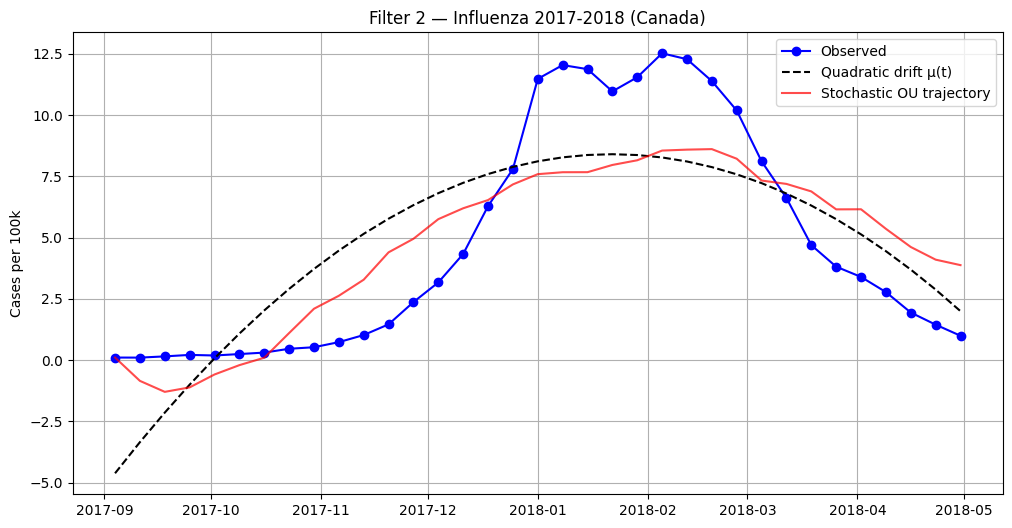

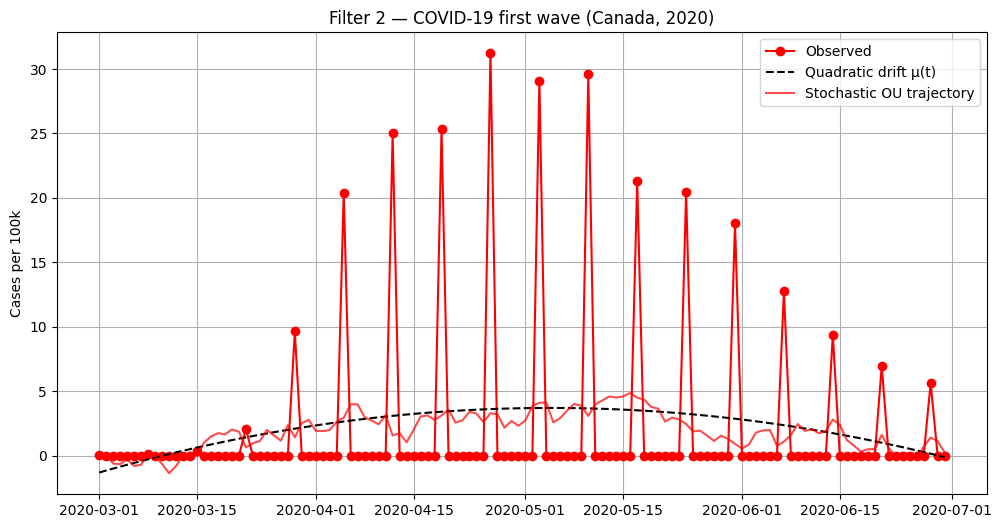

array([-1.20029918e-03,  1.55093633e-01, -1.31042240e+00])

In [9]:
# Influenza saison 2017-2018
flu_season = flu_canada.loc["2017-09-01":"2018-05-01"]["cases_per_100k"]
fit_and_simulate(flu_season, title="Filter 2 — Influenza 2017-2018 (Canada)", gamma=0.3, D=0.05, color_obs="blue")

# COVID première vague 2020
covid_wave = covid_canada.loc["2020-03-01":"2020-06-30"]["cases_per_100k"]
fit_and_simulate(covid_wave, title="Filter 2 — COVID-19 first wave (Canada, 2020)", gamma=0.3, D=0.2, color_obs="red")


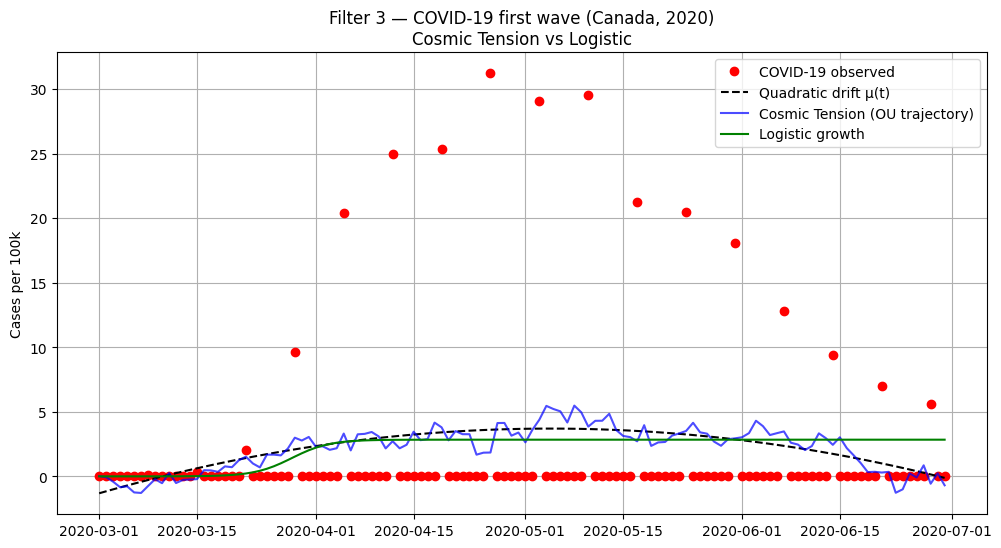

Logistic parameters: K=2.84, r=0.374, t0=27.6


In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# --- 1. Extraire la vague COVID (Canada, printemps 2020)
covid_wave = covid_canada.loc["2020-03-01":"2020-06-30"]["cases_per_100k"]
t = np.arange(len(covid_wave))
y = covid_wave.values

# --- 2. Ton modèle (quadratique déjà ajusté)
a, b, c = -0.0012003, 0.1550936, -1.3104224
mu = a*t**2 + b*t + c

# Simulation OU (stochastique)
gamma, D = 0.3, 0.2
phi = [y[0]]
for i in range(1, len(t)):
    drift = -gamma * (phi[-1] - mu[i])
    noise = np.sqrt(2*D) * np.random.randn()
    phi.append(phi[-1] + drift + noise)

# --- 3. Modèle logistique
def logistic(t, K, r, t0):
    return K / (1 + np.exp(-r*(t - t0)))

# Ajustement logistique
params_log, _ = curve_fit(logistic, t, y, p0=[max(y), 0.2, len(t)/2], maxfev=5000)
K, r, t0 = params_log
log_fit = logistic(t, K, r, t0)

# --- 4. Visualisation
plt.figure(figsize=(12,6))
plt.plot(covid_wave.index, y, 'o', label="COVID-19 observed", color="red")
plt.plot(covid_wave.index, mu, '--', label="Quadratic drift μ(t)", color="black")
plt.plot(covid_wave.index, phi, '-', label="Cosmic Tension (OU trajectory)", color="blue", alpha=0.7)
plt.plot(covid_wave.index, log_fit, '-', label="Logistic growth", color="green")
plt.title("Filter 3 — COVID-19 first wave (Canada, 2020)\nCosmic Tension vs Logistic")
plt.ylabel("Cases per 100k")
plt.legend()
plt.grid(True)
plt.show()

print("Logistic parameters: K=%.2f, r=%.3f, t0=%.1f" % (K, r, t0))


In [11]:
import pandas as pd
import numpy as np

# Fonctions d'erreur
def rmse(a, b):
    return np.sqrt(np.mean((a - b)**2))

def mae(a, b):
    return np.mean(np.abs(a - b))

# Comparer les trois modèles
resultats = []
for nom, pred in [
    ("Dérive quadratique μ(t)", mu),
    ("Cosmic Tension (OU)", phi),
    ("Croissance logistique", log_fit),
]:
    resultats.append({
        "Modèle": nom,
        "RMSE": rmse(y, pred),
        "MAE": mae(y, pred),
    })

# Créer un DataFrame et trier par RMSE
df_resultats = pd.DataFrame(resultats).sort_values("RMSE").reset_index(drop=True)
print("Comparaison des modèles (classés par RMSE croissant) :")
display(df_resultats)


Comparaison des modèles (classés par RMSE croissant) :


,Modèle,RMSE,MAE
0,Dérive quadratique μ(t),6.519341,3.852788
1,Croissance logistique,6.569643,3.745724
2,Cosmic Tension (OU),6.591859,3.903802


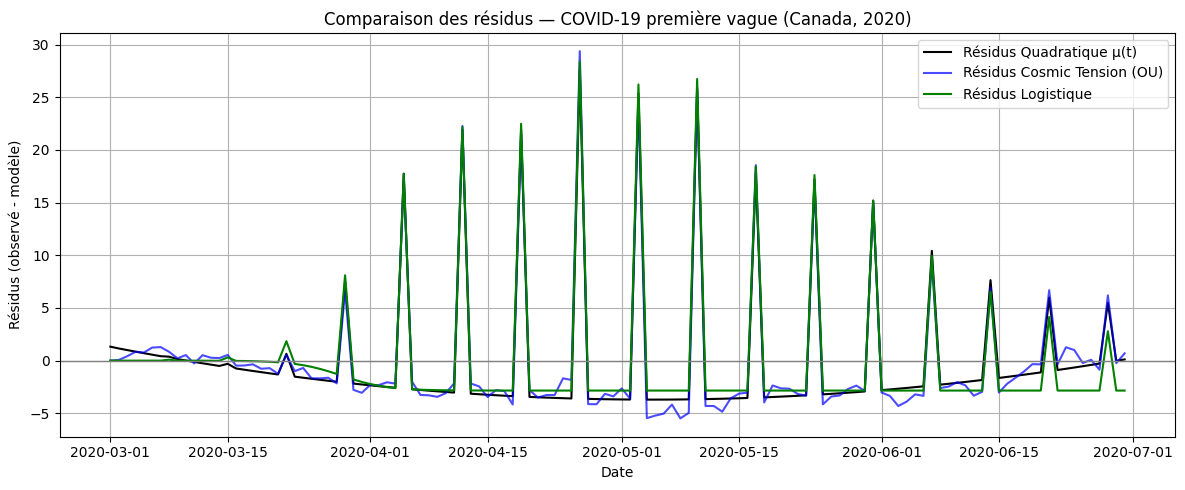

In [12]:
import matplotlib.pyplot as plt

# Calcul des résidus
res_quad = y - mu
res_ou   = y - phi
res_log  = y - log_fit

# Tracé
plt.figure(figsize=(12,5))
plt.plot(covid_wave.index, res_quad, label="Résidus Quadratique μ(t)", color="black")
plt.plot(covid_wave.index, res_ou, label="Résidus Cosmic Tension (OU)", color="blue", alpha=0.7)
plt.plot(covid_wave.index, res_log, label="Résidus Logistique", color="green")
plt.axhline(0, color="gray", lw=1)
plt.title("Comparaison des résidus — COVID-19 première vague (Canada, 2020)")
plt.ylabel("Résidus (observé - modèle)")
plt.xlabel("Date")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


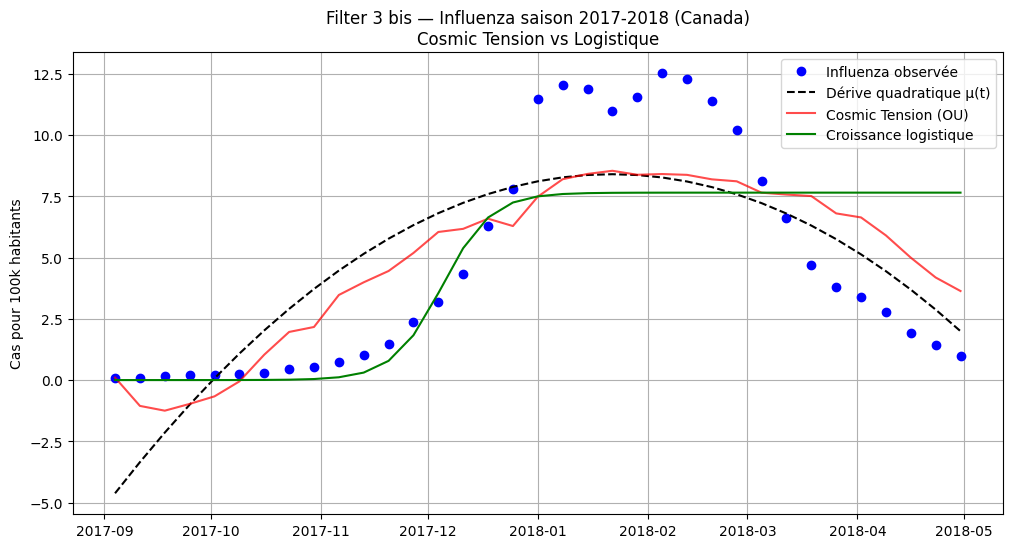

Paramètres logistiques (Influenza): K=7.65, r=1.012, t0=13.1


In [13]:
# 1. Extraire la saison de grippe 2017-2018
flu_season = flu_canada.loc["2017-09-01":"2018-05-01"]["cases_per_100k"]
t_flu = np.arange(len(flu_season))
y_flu = flu_season.values

# 2. Ajustement quadratique
params_flu, _ = curve_fit(quadratic, t_flu, y_flu, maxfev=5000)
a_f, b_f, c_f = params_flu
mu_flu = quadratic(t_flu, a_f, b_f, c_f)

# 3. Simulation OU
gamma, D = 0.3, 0.05
phi_flu = [y_flu[0]]
for i in range(1, len(t_flu)):
    drift = -gamma * (phi_flu[-1] - mu_flu[i])
    noise = np.sqrt(2*D) * np.random.randn()
    phi_flu.append(phi_flu[-1] + drift + noise)

# 4. Ajustement logistique
def logistic(t, K, r, t0):
    return K / (1 + np.exp(-r*(t - t0)))

params_log_flu, _ = curve_fit(logistic, t_flu, y_flu,
                              p0=[max(y_flu), 0.2, len(t_flu)/2],
                              maxfev=5000)
Kf, rf, t0f = params_log_flu
log_fit_flu = logistic(t_flu, Kf, rf, t0f)

# 5. Visualisation
plt.figure(figsize=(12,6))
plt.plot(flu_season.index, y_flu, 'o', label="Influenza observée", color="blue")
plt.plot(flu_season.index, mu_flu, '--', label="Dérive quadratique μ(t)", color="black")
plt.plot(flu_season.index, phi_flu, '-', label="Cosmic Tension (OU)", color="red", alpha=0.7)
plt.plot(flu_season.index, log_fit_flu, '-', label="Croissance logistique", color="green")
plt.title("Filter 3 bis — Influenza saison 2017-2018 (Canada)\nCosmic Tension vs Logistique")
plt.ylabel("Cas pour 100k habitants")
plt.legend()
plt.grid(True)
plt.show()

print("Paramètres logistiques (Influenza): K=%.2f, r=%.3f, t0=%.1f" % (Kf, rf, t0f))


In [14]:
# Fonctions d'erreur
def rmse(a, b):
    return np.sqrt(np.mean((a - b)**2))

def mae(a, b):
    return np.mean(np.abs(a - b))

# Comparer les trois modèles (Influenza)
resultats_flu = []
for nom, pred in [
    ("Dérive quadratique μ(t)", mu_flu),
    ("Cosmic Tension (OU)", phi_flu),
    ("Croissance logistique", log_fit_flu),
]:
    resultats_flu.append({
        "Modèle": nom,
        "RMSE": rmse(y_flu, pred),
        "MAE": mae(y_flu, pred),
    })

# Créer un DataFrame et trier par RMSE
df_resultats_flu = pd.DataFrame(resultats_flu).sort_values("RMSE").reset_index(drop=True)
print("Comparaison des modèles (Influenza 2017-2018, classés par RMSE croissant) :")
display(df_resultats_flu)


Comparaison des modèles (Influenza 2017-2018, classés par RMSE croissant) :


,Modèle,RMSE,MAE
0,Cosmic Tension (OU),2.538749,2.257623
1,Dérive quadratique μ(t),2.816010,2.491115
2,Croissance logistique,3.076893,2.249782
